# Average wake planes

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil, io
for x in amrwindfedirs: sys.path.insert(1, x)

%matplotlib inline

import postproamrwindsample_xarray as ppsample
import postproengine as ppeng
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml as yaml
    print("# Loaded ruamel.yaml")
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False} 
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    
if useruamel: Loader=yaml.load
else:         Loader=yaml.safe_load

from functools import partial

# Loaded ruamel.yaml


In [3]:
def stringReplaceDict(s, dreplace):
    outstr = str(s)
    for k, g in dreplace.items():
        outstr=outstr.replace(k, g)
    return outstr

In [4]:
def interppoints(xD):
    x = 240*xD
    ptlist = [[x, 0, z] for z in np.linspace(1, 240*2, 240*2)]
    return ptlist

ppeng.interppoints4 = partial(interppoints, 4)
ppeng.interppoints6 = partial(interppoints, 6)
ppeng.interppoints8 = partial(interppoints, 8)
ppeng.interppoints10 = partial(interppoints, 10)

def interpXY(xD):
    """
    Interpolate on the XY hub-height plane plane 
    """
    D  = 126.0
    x0 = D*4.0
    y0 = D*2.0
    z0 = 90.0
    x = D*xD
    #ptlist = [[x+x0, y+y0, z0] for y in np.linspace(-D*2, D*2, int(D*4+1))]
    ptlist = [[x+x0, y+y0] for y in np.linspace(-D*2, D*2, int(D*4+1))]
    return ptlist

for x in [1,2,3,4,5,6,7,8,9,10]:
    setattr(ppeng, 'interpXY'+repr(x), partial(interpXY, x))
    
    
def interpXZ(xD):
    """
    Interpolate on the XZ streamwise plane 
    """
    D  = 126.0
    x0 = D*4.0
    y0 = 0
    x = D*xD
    ptlist = [[x+x0, y+y0] for y in np.linspace(1, D*2, int(D*2))]
    return ptlist

for x in [1,2,3,4,5,6,7,8,9,10]:
    setattr(ppeng, 'interpXZ'+repr(x), partial(interpXZ, x))


In [5]:
#rundir='/gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_BD'
RUNDIR='/nscratch/gyalla/HFM/exawind-benchmarks/amr-wind/NREL5MW_ALM_BD/runs/'
RESULTSDIR='../results/'


In [6]:
yamlstring="""
globalattributes:
  verbose: False
  udfmodules: []
  executeorder:
  - avgworkflow

trange: &trange [15300, 15900]

interpXYstuff: &interpanchor
    pointlocationfunction: postproengine.interpXY4                    #Function to call to generate point locations. Function should have no arguments and return a list of points (Required)
    pointcoordsystem:   A1A2                                          #Coordinate system for point interpolation.  Options: XYZ, A1A2 (Required)
    varnames: ['velocityx_avg', 'velocityy_avg', 'velocityz_avg']     #List of variable names to extract. (Required)
    savefile: ../results/HHProfiles_300_900/XY_wake_04.csv

avgworkflow:
  avgplanes:
  - name: turbHH
    ncfile:
    - RUNDIR/post_processing/turbhh_30000.nc
    tavg: *trange
    varnames: [ 'velocityx', 'velocityy', 'velocityz']    #  
    #savepklfile:  avg_fixed_hhdomain.pkl         # Name of pickle file to save results (Optional, Default: '')
    #loadpklfile:  avg_fixed_hhdomain.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'NREL5MW ALM AVG horizontal velocity'
      xaxis: a1
      yaxis: a2     
      xlabel: "x/D"
      ylabel: "y/D"
      iplane: [0]
      clevels: np.linspace(0, 14, 141)
      cbar_nticks: 15
      xscalefunc: "lambda x: (x-504.0)/126.0"
      yscalefunc: "lambda y: (y-252.0)/126.0"
      savefile: '../results/images/turbineHH_AVG_300_900.png'
      plotturbines:
      - basexyz: [0.0, 0.0, 0]
        hubheight: 0.0
        rotordiameter: 1.0
        nacelledir: 270
        ix: 0
        iy: 1  

    interpolate:                                                        #ACTION: Interpolate data from an arbitrary set of points (Optional)
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY1
      savefile: ../results/HHProfiles_300_900/XY_wake_01.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY2
      savefile: ../results/HHProfiles_300_900/XY_wake_02.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY3
      savefile: ../results/HHProfiles_300_900/XY_wake_03.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY4
      savefile: ../results/HHProfiles_300_900/XY_wake_04.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY5
      savefile: ../results/HHProfiles_300_900/XY_wake_05.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY6
      savefile: ../results/HHProfiles_300_900/XY_wake_06.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY7
      savefile: ../results/HHProfiles_300_900/XY_wake_07.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY8
      savefile: ../results/HHProfiles_300_900/XY_wake_08.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXY9
      savefile: ../results/HHProfiles_300_900/XY_wake_09.csv

  - name: turbSW
    ncfile:
    - RUNDIR/post_processing/turbsw_30000.nc
    tavg: *trange
    #savepklfile:  avg_fixed_hhdomain.pkl         # Name of pickle file to save results (Optional, Default: '')
    #loadpklfile:  avg_fixed_hhdomain.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'NREL5MW ALM AVG horizontal velocity'
      xaxis: a1
      yaxis: a2
      xlabel: "x/D"
      ylabel: "$(z-z_h)/D$"      
      iplane: [0]
      clevels: np.linspace(0, 14, 141)
      cbar_nticks: 8
      xscalefunc: "lambda x: (x-504.0)/126.0"
      yscalefunc: "lambda y: (y-90.0)/126.0"
      savefile: '../results/images/turbineSW_AVG_300_900.png'
      plotturbines:
      - basexyz: [0.0, 0.0, 0]
        hubheight: 0.0
        rotordiameter: 1.0
        nacelledir: 270
        ix: 0
        iy: 2  


    interpolate:
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ1
      savefile: ../results/XZProfiles_300_900/XZ_wake_01.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ2
      savefile: ../results/XZProfiles_300_900/XZ_wake_02.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ3
      savefile: ../results/XZProfiles_300_900/XZ_wake_03.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ4
      savefile: ../results/XZProfiles_300_900/XZ_wake_04.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ5
      savefile: ../results/XZProfiles_300_900/XZ_wake_05.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ6
      savefile: ../results/XZProfiles_300_900/XZ_wake_06.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ7
      savefile: ../results/XZProfiles_300_900/XZ_wake_07.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ8
      savefile: ../results/XZProfiles_300_900/XZ_wake_08.csv
    - << : *interpanchor
      pointlocationfunction: postproengine.interpXZ9
      savefile: ../results/XZProfiles_300_900/XZ_wake_09.csv



"""
f = io.StringIO(stringReplaceDict(yamlstring, {'RUNDIR':RUNDIR, 'RESULTSDIR':RESULTSDIR}))
yamldict = Loader(f, **loaderkwargs)

Initialized avgplanes
Running avgplanes
/nscratch/gyalla/HFM/exawind-benchmarks/amr-wind/NREL5MW_ALM_BD/runs//post_processing/turbhh_30000.nc 697
[============================================================] 100.0% 
Ncount = 697

Initialized contourplot inside avgplanes
Executing contourplot
Initialized interpolate inside avgplanes
Executing interpolate
/nscratch/gyalla/HFM/exawind-benchmarks/amr-wind/NREL5MW_ALM_BD/runs//post_processing/turbsw_30000.nc 697
[============================================================] 100.0% 
Ncount = 697

Initialized contourplot inside avgplanes
Executing contourplot
Initialized interpolate inside avgplanes
Executing interpolate


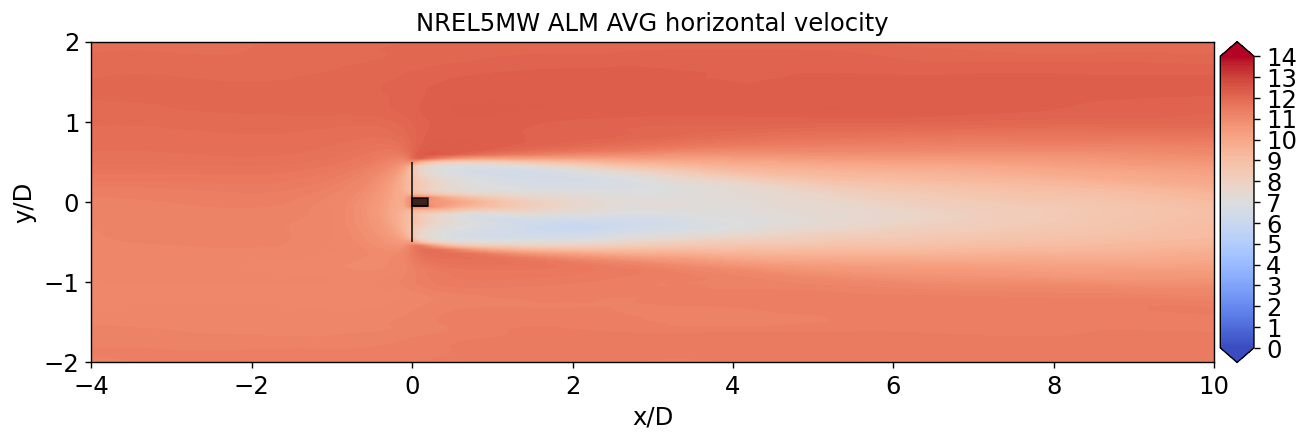

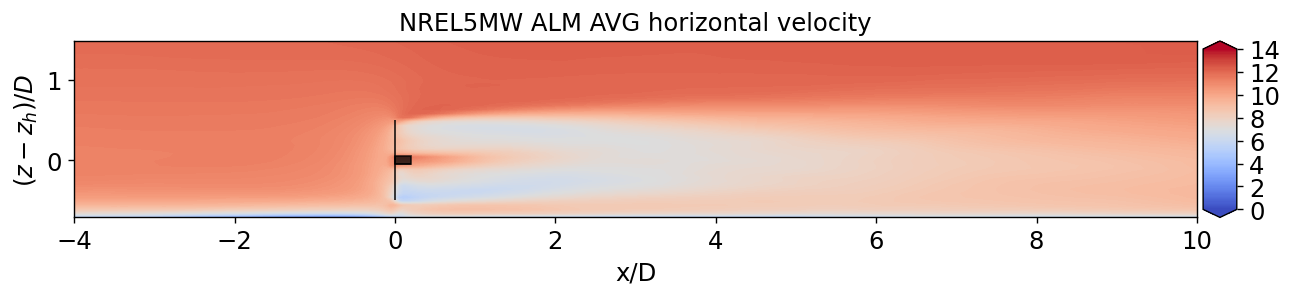

In [7]:
# Run the driver
ppeng.driver(yamldict, verbose=True)

In [8]:
# Write out the notebook to a python script
!jupyter nbconvert --to script AVGPlanes.ipynb
with open('AVGPlanes.py', 'r') as f:
    lines = f.readlines()
with open('AVGPlanes.py', 'w') as f:
    for line in lines:
        if 'nbconvert --to script' in line:
            break
        else:
            f.write(line)

[NbConvertApp] Converting notebook AVGPlanes.ipynb to script
[NbConvertApp] Writing 8466 bytes to AVGPlanes.py
